In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv("../dataset/train.csv")
y_train = df['price']
x_train = df.drop(columns=['price'])
x_train.shape, y_train.shape

((15035, 20), (15035,))

In [34]:
df_test = pd.read_csv("../dataset/test.csv")
df_test.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [35]:
df_test['date'] = df_test['date'].map(lambda x: int(x.split('T')[0]))
df_test['date'].min()

20140502

### 기본 선형모델(feature를 추가하지 않은)
- feature drop
    - id, date, zipcode (drop)
- OLS

In [7]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + C(waterfront) \
                    + view + condition + grade + sqft_above + sqft_basement + yr_built \
                    + yr_renovated + lat + long + sqft_living15 + sqft_lot15 - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3131.
Date:                Tue, 02 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:13:29   Log-Likelihood:                -689.49
No. Observations:               15035   AIC:                             1413.
Df Residuals:                   15018   BIC:                             1542.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(waterfront)[0]   -52.4150      2.389  

- price보다 np.log1p(price)를 해주는게 R square가 높다..
- condition number가 너무 크다.

1. std err : 표준오차(standard error) ; 
2. t : (w_hat - w) / std_err = t
3. p>|t| : "w가 0이다"라는 귀무가설의 유의확률; t의 유의확률
4. F statistics : 


---
### EDA를 통해 사용해볼 features
- 47.5~47.8도 사이에 위치한 zipcode --> 중심지와 교외지역
- 부지면적(sqft_lot) 대비 거주면적(sqft_living) 비율
- 거주면적(sqft_living) 대비 지상면적(sqft_above) 비율
- 재건축 여부 (yr_renovated)
- 선거연도에 지어졌는지 유무(election_year)

In [3]:
# 먼저 독립변수들간의 상관관계를 조금 줄여보자
# sqft_above, sqft_basement drop
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + C(waterfront) \
                    + view + condition + grade + yr_built \
                    + yr_renovated + lat + long + sqft_living15 + sqft_lot15 - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3337.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:33:55   Log-Likelihood:                -693.64
No. Observations:               15035   AIC:                             1419.
Df Residuals:                   15019   BIC:                             1541.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(waterfront)[0]   -53.9802      2.327  

- condition number가 많이 줄었다
- scaling을 해주자

In [5]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + view + condition + grade + scale(lat) + scale(long) + scale(sqft_living15) + scale(sqft_lot15) - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3496.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:37:40   Log-Likelihood:                -1246.8
No. Observations:               15035   AIC:                             2522.
Df Residuals:                   15021   BIC:                             2628.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(waterfront)[0]        11.5416 

- lat/long까지 scaling해줬더니 conditional number가 급감하였다.

In [3]:
df2 = df.copy()

In [4]:
# 평당가격 (실제론 피트당 가격)
# sqft_living
df2['per_price'] = df2['price'] / df2['sqft_living']
price_per_zipcode = df2.groupby(['zipcode'])['per_price'].agg({'zipprice_mean' : 'mean', 'zipprice_std' : np.std}).reset_index()
price_per_zipcode.tail()

price_per_zipcode['zipprice_mean'].describe()

# 평당가격이 317 이상되면 중심부가 아닐까?

# merge df2 and price_per_zipcode
df2 = df2.merge(price_per_zipcode, how='left', on='zipcode')
df2.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,per_price,zipprice_mean,zipprice_std
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,2014,0,98056,47.5137,-122.167,2520,6023,242.335317,215.244097,64.696581
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,2009,0,98136,47.5537,-122.398,2050,6200,287.037037,336.554976,96.875640
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,2009,0,98103,47.6993,-122.346,1530,1509,235.294118,371.460150,97.427992
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,2014,0,98146,47.5107,-122.362,1830,7200,173.160173,223.377191,85.597885
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,2008,0,98144,47.5941,-122.299,1020,1357,318.627451,319.292642,91.391157


In [5]:
idx = df2[(df2.zipprice_mean > 317.) & (df2.lat >= 47.5) & (df2.lat < 47.8)].index
df2['center_region'] = 0
df2.loc[idx, 'center_region'] = 1
df2.center_region

0        0
1        0
2        0
3        0
4        0
5        0
6        1
7        0
8        0
9        1
10       0
11       0
12       1
13       0
14       0
15       0
16       1
17       0
18       0
19       0
20       1
21       1
22       0
23       1
24       1
25       0
26       1
27       1
28       0
29       0
        ..
15005    0
15006    0
15007    0
15008    1
15009    0
15010    1
15011    1
15012    1
15013    0
15014    1
15015    1
15016    0
15017    1
15018    0
15019    1
15020    0
15021    0
15022    0
15023    0
15024    0
15025    1
15026    0
15027    1
15028    0
15029    0
15030    0
15031    1
15032    1
15033    0
15034    1
Name: center_region, Length: 15035, dtype: int64

In [6]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + view + condition + grade + scale(lat) + scale(long) + scale(sqft_living15) + scale(sqft_lot15) + C(center_region) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     5106.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                 1445.4
No. Observations:               15035   AIC:                            -2861.
Df Residuals:                   15020   BIC:                            -2747.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(waterfront)[0]         11.71

- conditional number는 큰 변동없음.(25이하까지 떨어뜨려야하는 것으로 알고 있음.)
- R square 값이 올랐다 (0.75 --> 0.82)

In [9]:
df2['is_renovated'] = df2['yr_renovated'].map(lambda x : 0 if x == 0 else 1)
df2['is_election_year'] = df2['yr_built'].map(lambda x : 1 if x % 4 == 0 else 0)

In [18]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + I(view / condition) + grade + scale(lat) + scale(long) + scale(sqft_living15) \
                    + scale(sqft_lot15) + C(center_region) + C(is_renovated) + C(is_election_year) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     4531.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:54:23   Log-Likelihood:                 1134.3
No. Observations:               15035   AIC:                            -2237.
Df Residuals:                   15019   BIC:                            -2115.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(waterfront)[0]        

In [24]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + I(scale(sqft_living / sqft_living15)) + scale(sqft_lot) + floors + C(waterfront) \
                    + I(view / condition) + grade + scale(lat) + scale(long) \
                    + scale(sqft_lot15) + C(center_region) + C(is_renovated) + C(is_election_year) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     4401.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:58:42   Log-Likelihood:                 955.22
No. Observations:               15035   AIC:                            -1878.
Df Residuals:                   15019   BIC:                            -1757.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

---

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv("../dataset/train.csv")
df_test = pd.read_csv("../dataset/test.csv")
train_id = df_train.id
test_id = df_test.id
df_train.shape, df_test.shape

((15035, 21), (6468, 20))

In [4]:
df_train[df_train.sqft_living > 10000].index

Int64Index([2775, 5108, 8912], dtype='int64')

In [5]:
df_train = df_train.drop(index=8912)

In [6]:
df_train.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [7]:
# data preprocessing
# test도 형태를 맞춰준다.

# 중심지인지 아닌지 : is_center
# def is_center(train, test):
#     # 평당가격 (실제론 피트당 가격)
#     # sqft_living
#     train['per_price'] = train['price'] / train['sqft_living']
#     price_per_zipcode = train.groupby(['zipcode'])['per_price'].agg({'zipprice_mean' : 'mean', 'zipprice_std' : np.std}).reset_index()

#     # 평당가격이 317 이상되면 중심부가 아닐까?

#     # merge df2 and price_per_zipcode
#     train = train.merge(price_per_zipcode, how='left', on='zipcode')
#     test = test.merge(price_per_zipcode, how='left', on='zipcode')

#     # 317.146477의 의미는 zipcode별 피트당 가격의 상위 25%
#     train_idx = train[(train.zipprice_mean >= 317.146477) & (train.lat >= 47.5) & (train.lat < 47.8)].index
#     test_idx = test[(test.zipprice_mean >= 317.146477) & (test.lat >= 47.5) & (test.lat < 47.8)].index
#     train['is_center'] = 0
#     test['is_center'] = 0
#     train.loc[train_idx, 'is_center'] = 1
#     test.loc[test_idx, 'is_center'] = 1
    
#     train.drop(columns=['zipprice_mean','per_price','zipprice_std'], inplace=True)
#     test.drop(columns=['zipprice_mean','zipprice_std'], inplace=True)
#     return train, test

# 재건축(?)했는지 안했는지
#def is_renovated(train, test):
#    train['is_renovated'] = train['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
#    test['is_renovated'] = test['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
#    return train, test
    
# 지어진지 몇년되었는지
def years_of_construction(train, test):
    train['years_of_construction'] = 2015 - train['yr_built']
    test['years_of_construction'] = 2015 - test['yr_built']
    return train, test

# 'price' --> log scaling 해준다.
# 단, 이렇게 해주면 제출시 np.exp()씌워주자
def target_logscaling(train):
    train['log_price'] = np.log1p(train['price'])
    return train

#def buy_year_dummy(train, test):
#    train['buy_year'] = train['date'].map(lambda x : int(x.split('T')[0][:4]))
#    test['buy_year'] = test['date'].map(lambda x : int(x.split('T')[0][:4]))
#
#    train['buy_2014'] = train['date'].map(lambda x : 1 if x == 2014 else 0)
#    train['buy_2015'] = train['date'].map(lambda x : 1 if x == 2015 else 0)
#    
#    test['buy_2014'] = test['date'].map(lambda x : 1 if x == 2014 else 0)
#    test['buy_2015'] = test['date'].map(lambda x : 1 if x == 2015 else 0)
#    
#    return train, test

    
from sklearn.preprocessing import StandardScaler

cols = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long','years_of_construction']
def make_normal(train, test, cols):
    """
    평균0으로 scaling (standardization)
    train의 평균, 표준편차 사용하여 test noramlize!!
    대상 columns : ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']
    """
    # mean_ls = list(train[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']].mean(axis=0))
    scaler = StandardScaler()
    scaler.fit(train[cols])
    temp1 = scaler.transform(train[cols])
    temp1 = pd.DataFrame(data=temp1,columns=cols, dtype=np.float32)
    df1 = train.drop(columns=cols)
    df_train = pd.concat([df1, temp1], axis=1)
    
    temp2 = scaler.transform(test[cols])
    temp2 = pd.DataFrame(data=temp2, columns=cols ,dtype=np.float32)
    df2 = test.drop(columns=cols)
    df_test = pd.concat([df2, temp2], axis=1)
    
    return df_train, df_test

def column_selection(train, drop_cols):
    cols = list(train.columns)
    for drop_col in drop_cols:
        if drop_col in cols:
            idx = cols.index(drop_col)
            cols.pop(idx)
    
    return cols

# 가장 비싼 집과의 거리
def get_distance_from_max(train, test):
    """
    train set에서 가장 비싼 집과 떨어진 거리 계산
    """
    max_idx = train[train['price'] == train['price'].max()].index[0]
    max_location = np.array(train[['lat','long']].loc[max_idx,:]) # 가장 비싼 집의 좌표
    train_location = np.array(train[['lat','long']])
    test_location = np.array(test[['lat','long']])
    # compute distance : ||location1 - location2||
    distance_from_max_train = sp.linalg.norm(max_location - train_location, axis=1)
    distance_from_max_test = sp.linalg.norm(max_location - test_location, axis=1)
    return distance_from_max_train, distance_from_max_test


def local_features_append(train, test):
    """
    지역성을 보여주는 column추가    
    """
    # 47.5~47.7도 사이의 지역인지 아닌지
    train['is_center'] = train['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)
    test['is_center'] = test['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)

    # above와 basement의 비율
    train['ratio_above/living'] = train['sqft_above'] / train['sqft_living']
    train['ratio_basement/living'] = train['sqft_basement'] / train['sqft_living']
    
    test['ratio_above/living'] = test['sqft_above'] / test['sqft_living']
    test['ratio_basement/living'] = test['sqft_basement'] / test['sqft_living']
    
    # 면적의 차이 : sqft_living - sqft_living15, sqft_lot - sqft_lot15
    train['living_diff'] = train['sqft_living'] - train['sqft_living15']
    test['living_diff'] = test['sqft_living'] - test['sqft_living15']
    
    return train, test

# zipcode dummy화
#df_train = pd.concat([df_train,pd.get_dummies(data=df_train['zipcode'], columns=['zipcode'], prefix='zipcode')], axis=1)
#df_test = pd.concat([df_test,pd.get_dummies(data=df_test['zipcode'], columns=['zipcode'], prefix='zipcode')], axis=1)

df_train['date'] = df_train['date'].map(lambda x : int(x.split('T')[0]))
df_test['date'] = df_test['date'].map(lambda x : int(x.split('T')[0]))
# # sqft_living > sqft_living15 : categorical로 만들기
# def which_bigger(train, test):
    

In [8]:
df_train, df_test = local_features_append(df_train, df_test)
df_train['distance_from_max'], df_test['distance_from_max'] = get_distance_from_max(df_train, df_test)
df_train, df_test = years_of_construction(df_train, df_test)
df_train, df_test = is_renovated(df_train, df_test)
#df_train, df_test = make_normal(df_train, df_test, 
#                                cols=['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15', 'long','lat'])
df_train = target_logscaling(df_train)

In [9]:
df_train.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,is_center,ratio_above/living,ratio_basement/living,living_diff,distance_from_max,years_of_construction,is_renovated,log_price
15030,15030,20141014,610685.0,4,2.50,2520,6023,2.0,0,0,...,2520,6023,1,1.000000,0.000000,0,0.194461,1,0,13.322338
15031,15031,20150326,1007500.0,4,3.50,3510,7200,2.0,0,0,...,2050,6200,1,0.740741,0.259259,1460,0.106847,6,0,13.822984
15032,15032,20140521,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,1509,1,1.000000,0.000000,0,0.073207,6,0,12.793862
15033,15033,20150223,400000.0,4,2.50,2310,5813,2.0,0,0,...,1830,7200,1,1.000000,0.000000,480,0.125323,1,0,12.899222
15034,15034,20141015,325000.0,2,0.75,1020,1076,2.0,0,0,...,1020,1357,1,1.000000,0.000000,0,0.043017,7,0,12.691584


In [10]:
df_train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'is_center',
       'ratio_above/living', 'ratio_basement/living', 'living_diff',
       'distance_from_max', 'years_of_construction', 'is_renovated',
       'log_price'],
      dtype='object')

In [11]:
training_cols = column_selection(df_train, drop_cols=['id','log_price','price'])
target = df_train['log_price']
df_train, df_test = df_train[training_cols], df_test[training_cols]

In [12]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 35,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 0,
         "categorical_feature=name" : 'zipcode'
        }

y_reg = target

#prepare fit model with cross-validation
folds = KFold(n_splits=4, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 0.0183069	valid_1's l2: 0.0271026
[1000]	training's l2: 0.0135317	valid_1's l2: 0.0260051
[1500]	training's l2: 0.0106237	valid_1's l2: 0.0257598
[2000]	training's l2: 0.00858729	valid_1's l2: 0.0257159
Early stopping, best iteration is:
[2017]	training's l2: 0.0085299	valid_1's l2: 0.0257106
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 0.0182828	valid_1's l2: 0.0266498
[1000]	training's l2: 0.0135172	valid_1's l2: 0.02558
[1500]	training's l2: 0.010713	valid_1's l2: 0.0253882
Early stopping, best iteration is:
[1487]	training's l2: 0.0107749	valid_1's l2: 0.0253782
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 0.0184222	valid_1's l2: 0.0247842
[1000]	training's l2: 0.0135316	valid_1's l2: 0.0240863
[1500]	training's l2: 0.0106541	valid_1's l2: 0.0239582
[2000]	training's l2: 0.00863088	valid_1's l2: 0.0239481
Early stopping, b

In [13]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

117905.0641794892


In [14]:
np.expm1(predictions)

array([ 503020.26813011,  478832.13813153, 1325913.6033927 , ...,
        472775.07706728,  314308.73352531,  428929.66038248])

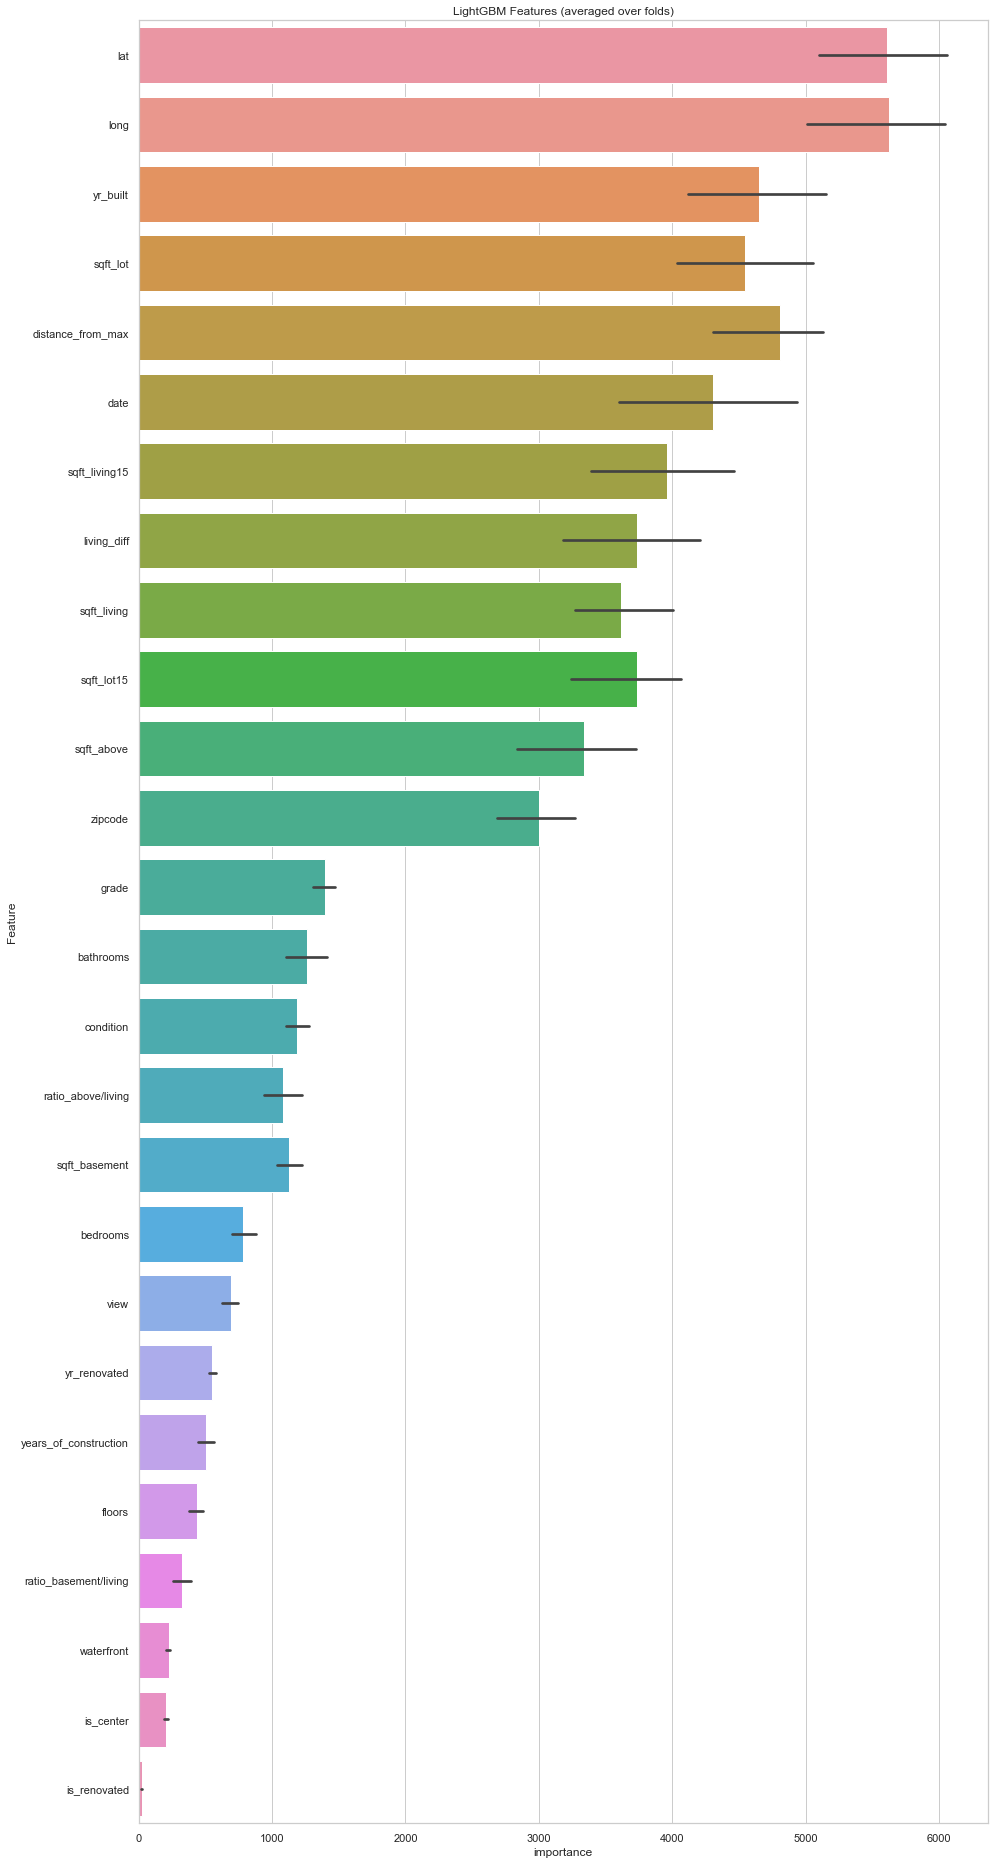

In [15]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [17]:
submission = pd.read_csv("../dataset/sample_submission.csv")
submission.tail()

,id,price
6463,21498,100000
6464,21499,100000
6465,21500,100000
6466,21501,100000
6467,21502,100000


In [18]:
submission['price'] = np.expm1(predictions)
submission.tail()

,id,price
6463,21498,251861.569124
6464,21499,393638.976543
6465,21500,472775.077067
6466,21501,314308.733525
6467,21502,428929.660382


In [19]:
submission.to_csv("8_submission.csv", index=False)